# CS 224U Final Project: Relation Extraction with Graph Embeddings

**Authors:** Ben Barnett and Aakash Pattabi

In [1]:
import numpy as np
import torch
import json
import sys
from pycorenlp import StanfordCoreNLP
from collections import defaultdict
import subprocess

### 1. Loading TACRED data

In [2]:
train_path = "tacred-relation/dataset/tacred/train.json"
eval_path = "tacred-relation/dataset/tacred/dev.json"
test_path = "tacred-relation/dataset/tacred/test.json"

with open(train_path, "rb") as f:
    train_data = json.load(f)
    
with open(eval_path, "rb") as f:
    eval_data = json.load(f)
    
with open(test_path, "rb") as f:
    test_data = json.load(f)

sanity = train_data[0]
print(sanity)

{'id': '61b3a65fb906688c92a1', 'relation': 'no_relation', 'token': ['Ali', 'lied', 'about', 'having', 'to', 'leave', 'for', 'her', 'job', 'to', 'see', 'if', 'Jake', 'would', 'end', 'the', 'show', 'to', 'be', 'with', 'her', '.'], 'subj_start': 20, 'subj_end': 20, 'obj_start': 12, 'obj_end': 12, 'subj_type': 'PERSON', 'obj_type': 'PERSON', 'stanford_pos': ['NNP', 'VBD', 'IN', 'VBG', 'TO', 'VB', 'IN', 'PRP$', 'NN', 'TO', 'VB', 'IN', 'NNP', 'MD', 'VB', 'DT', 'NN', 'TO', 'VB', 'IN', 'PRP', '.'], 'stanford_ner': ['PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'stanford_head': ['2', '0', '4', '2', '6', '4', '11', '9', '11', '11', '6', '15', '15', '15', '11', '17', '15', '21', '21', '21', '17', '2'], 'stanford_deprel': ['nsubj', 'ROOT', 'mark', 'advcl', 'mark', 'xcomp', 'mark', 'nmod:poss', 'nsubj', 'mark', 'advcl', 'mark', 'nsubj', 'aux', 'advcl', 'det', 'dobj', 'mark', 'cop', 'case', 'acl', 'punct']}


### 2. Defining a sentence-level feature extractor

In [46]:
class GraphFeatureExtractor(object):
    def __init__(self, server, parse_level = "basic", 
                 embedding_path = None):
        self.server = server
        self.set_parse_level(parse_level)
        
        # Initialize word embeddings
        if embedding_path:
            self.embedding_path = embedding_path
            self._load_embeddings()
        else:
            self.embedding_path = None
            
        self._reset_class_distribution()
        self._reset_class_labels()
    
    def _reset_class_labels(self):
        self.class_labels = {}
    
    def _reset_class_distribution(self):
        self.class_distribution = defaultdict(int)
        self.sentences_seen = 0
        
    def _load_embeddings(self):
        self.embeddings = {}
        with open(self.embedding_path, "r") as f:
            for line in f:
                tokens = line.split()
                self.embeddings[tokens[0]] = [float(i) for i in tokens[1:]]
    
    def get_class_labels(self):
        return self.class_labels
    
    def set_parse_level(self, parse_level):
        assert parse_level in ["basic", "enhanced", "extra_enhanced"]
        d = {
            "basic" : "basicDependencies",
            "enhanced" : "enhancedDependencies", 
            "extra_enhanced" : "enhancedPlusPlusDependencies"
        }
        self.parse_level = d[parse_level]
    
    def _extract_graph(self, sentence):
        Y = sentence["relation"]
        self.class_distribution[Y] += 1
        self.sentences_seen += 1
        if Y not in self.class_labels:
            self.class_labels[Y] = len(self.class_labels)
        
        # Extract tokens, subsentence (b/w subj->obj tokens)
        tokens = sentence["token"]
        first = min(sentence["subj_end"], sentence["obj_end"])
        second = max(sentence["subj_start"], sentence["obj_start"])
        middle = tokens[first+1:second]

        # Concatenate full sentence and sentence middle (b/w subj->obj tokens)
        full_sentence = " ".join(tokens)
        full_middle = " ".join(middle)
        
        # Parse with Stanford parser
        full_sentence_out = server.annotate(full_sentence, properties = {
            "annotators" : "parse", 
            "outputFormat" : "json"
        })
        middle_out = server.annotate(full_middle, properties = {
            "annotators" : "parse", 
            "outputFormat" : "json"
        })
        
        # Extract graph edgelist
        X_full = self._parse_to_graph(full_sentence_out)
        X_middle = self._parse_to_graph(middle_out)
        
        # Add word-level GloVe features to graph inputs
        if self.embedding_path:
            X_full["features"] = self._get_embedding_features(tokens)
            X_middle["features"] = self._get_embedding_features(middle)
        
        return {"full" : X_full, "middle" : X_middle, "Y" : Y}
        
    def _parse_to_graph(self, parse):
        dep_list = parse["sentences"][0][self.parse_level]
        dep_graph = defaultdict(lambda : [])
        for d in dep_list:
            dep_graph[d["governor"]].append(d["dependent"])
        return self._convert_to_edgelist(dep_graph)
    
    def _convert_to_edgelist(self, dep_graph):
        el = {
            "edges" : [[k, vi] for k, v in dep_graph.items() for vi in v] 
        }        
        return el
    
    def _get_embedding_features(self, sent, embedding_dim = 50):
        feats = {}
        for i, token in enumerate(sent):
            features = self.embeddings.get(token, None)
            if not features:
                features = [np.random.rand() for j in range(embedding_dim)]
            feats[i+1] = features
            
        # By default, we assign the [ROOT] token in the parse tree an embedding vector
        # of all zeroes... mostly because I'm not strictly sure what else to do here. @Ben, thoughts?
        feats[0] = [0]*embedding_dim
        return feats
    
    def extract_batch_graphs(self, sentences):
        return [self._extract_graph(s) for s in sentences]
    
    def extract_resampled_graphs(self, sentences, total):
        n_to_resample = total - len(sentences)
        if n_to_resample <= 0:
            return
        
        resampled_sentences = []
        while n_to_resample > 0:
            for sent in sentences:
                rel = sent["relation"]
                frequency = self.class_distribution[rel]/self.sentences_seen
                keep = (np.random.rand() > frequency)
                if keep:
                    resampled_sentences.append(sent)
                    n_to_resample -= 1
        return self.extract_batch_graphs(resampled_sentences)
    
    def save_jsons(self, graphs, save_path):
        assert save_path and save_path[-1] == "/"
        for i, g in enumerate(graphs):
            with open(save_path + str(i) + ".json", "w") as f:
                json.dump(g, f)
    
    def concat_with_mean_embedding(self, features, embedding_dicts):
        n, d = features.shape
        mean_embeddings = []
        for i in range(n):
            mean_embeddings.append(np.mean([v for k, v in embedding_dicts[i].items()], axis = 0))
        return np.concatenate((features, mean_embeddings), axis = 1)
    
    def concat_with_sum_embedding(self, features, embedding_dicts):
        n, d = features.shape
        mean_embeddings = []
        for i in range(n):
            mean_embeddings.append(np.sum([v for k, v in embedding_dicts[i].items()], axis = 0))
        return np.concatenate((features, mean_embeddings), axis = 1)

Below, we generate all graph features (with 50-dimensional GloVe) vectors for the TACRED training set. Each sentence-level graph (over the entire sentence and over only the "bridge" words between the subject and the object) is saved to a .json file which we then post-process with Graph2Vec. 

In [13]:
embedding_path = "./glove/glove.6B.50d.txt"
server = StanfordCoreNLP("http://localhost:9000")

fe = GraphFeatureExtractor(server, embedding_path = embedding_path)
feats = fe.extract_batch_graphs(train_data)

full_save_path = "./train_features_full/"
fe.save_jsons([feat["full"] for feat in feats], save_path = full_save_path)

middle_save_path = "./train_features_middle/"
fe.save_jsons([feat["middle"] for feat in feats], save_path = middle_save_path)

Then, we call Graph2Vec from command-line using a subprocess to generate the sentence features. 

In [5]:
feats_path = full_save_path
out_path = "./train_features_full_g2v/train_features_full.csv"

success = subprocess.call(
    ["python", 
     "graph2vec/src/graph2vec.py", 
     "--input-path", feats_path, 
     "--output-path", out_path]
)
assert success == 0

Finally, we can load the newly extracted features from the .csv file and use them in an arbitrary classifier.

In [17]:
import pandas as pd

X = pd.read_csv(out_path, sep = ",").drop(labels = ["type"], axis = 1)
X = np.array(X)
X = fe.concat_with_mean_embedding(X, [feat["full"]["features"] for feat in feats])
X = fe.concat_with_sum_embedding(X, [feat["full"]["features"] for feat in feats])
print(X.shape)

(20, 228)


Additional features to implement:
1. ~~Resampling of the original data to augment data size + reduce class imbalance that *doesn't* duplicate Graph2Vec features across repeated samples.~~
2. Creating a full TAC dataset-to-features pipeline that can be deployed on arbitrary data 
3. Incorporation of e.g. parse tree label information into the features. 
4. Classifiers - implement logistic regression, set up as a neural network. 

### 3. Defining a full feature-extraction pipeline that can be used on arbitrary data

In [44]:
class FeatureExtractorPipeline(object):
    def __init__(self, fe_args, save_paths):
        self.fe = GraphFeatureExtractor(**fe_args)
        self.save_paths = save_paths
        self.class_labels = None
    
    def _one_hot(self, length, hot):
        a = np.zeros(length)
        a[hot] = 1
        return a
    
    def _extract_training_graphs(self, sentences, total, train_flag):
        feats = self.fe.extract_batch_graphs(sentences)
        if total > len(sentences):
            resampled_feats = self.fe.extract_resampled_graphs(sentences, total)
            feats += resampled_feats
        assert len(feats) == total    
        
            
        self.fe.save_jsons(
            [feat["full"] for feat in feats], 
            self.save_paths[train_flag + "_full_save_path"]
        )
        self.fe.save_jsons(
            [feat["middle"] for feat in feats], 
            self.save_paths[train_flag + "_middle_save_path"]
        )
        
        self.class_labels = self.fe.get_class_labels()
        n_classes = len(self.class_labels)
        Y = [self._one_hot(n_classes, self.class_labels[feat["Y"]]) for feat in feats]
        X_full_embs = [feat["full"]["features"] for feat in feats]
        X_middle_embs = [feat["middle"]["features"] for feat in feats]
        
        return Y, X_full_embs, X_middle_embs
    
    def _extract_training_embeddings(self, 
                                     X_full_embs, X_middle_embs,
                                     train_flag, 
                                     concat = "mean"):
        assert concat in ["mean", "sum", "both"]
        
        success_full = subprocess.call(
            ["python", 
             "graph2vec/src/graph2vec.py", 
             "--input-path", self.save_paths[train_flag + "_full_save_path"], 
             "--output-path", self.save_paths[train_flag + "_full_g2v_path"]]
        )
        assert success_full == 0
        
        success_middle = subprocess.call(
            ["python", 
             "graph2vec/src/graph2vec.py", 
             "--input-path", self.save_paths[train_flag + "_middle_save_path"], 
             "--output-path", self.save_paths[train_flag + "_middle_g2v_path"]]
        )
        assert success_middle == 0
        
        X_full = pd.read_csv(
            self.save_paths[train_flag + "_full_g2v_path"], sep = ",").drop(labels = ["type"], axis = 1)
        X_full = np.array(X_full)
        
        X_middle = pd.read_csv(
            self.save_paths[train_flag + "_middle_g2v_path"], sep = ",").drop(labels = ["type"], axis = 1)
        X_middle = np.array(X_middle)
        
        if concat == "mean" or concat == "both":
            X_full = fe.concat_with_mean_embedding(X_full, X_full_embs)
            X_middle = fe.concat_with_mean_embedding(X_middle, X_middle_embs)
        elif concat == "sum" or concat == "both":
            X_full = fe.concat_with_sum_embedding(X_full, X_full_embs)
            X_middle = fe.concat_with_sum_embedding(X_middle, X_middle_embs)
        
        return X_full, X_middle
    
    def get_class_labels(self):
        return self.class_labels
    
    def extract_features(self, sentences, total = 0, train_flag = "train"):
        assert train_flag in ["train", "test"]
        
        print("Building graphs from sentence dependency trees...")
        Y, X_full_embs, X_middle_embs = self._extract_training_graphs(sentences, total, train_flag)
        print("Extracting Graph2Vec embeddings and annotationg w/ GloVe vecs...")
        X_full, X_middle = self._extract_training_embeddings(X_full_embs, X_middle_embs, train_flag)
        print("Done!")
        return np.array(Y), X_full, X_middle

In [47]:
fe_args = {
    "server" : server, 
    "embedding_path" : embedding_path
}

save_paths = {
    "train_full_save_path" : "train_features_full/", 
    "train_middle_save_path" : "train_features_middle/",
    "test_full_save_path" : None, 
    "test_middle_save_path" : None,
    "train_full_g2v_path" : "train_features_full_g2v/features.csv",
    "train_middle_g2v_path" : "train_features_middle_g2v/features.csv",
    "test_full_g2v_path" : None, 
    "test_middle_g2v_path" : None
}

n_samples = len(train_data)
print("Originally {} samples in training data...".format(n_samples))
fep = FeatureExtractorPipeline(fe_args, save_paths)
Y, X_full, X_middle = fep.extract_features(train_data, total = 100)
print("Now, resampled up to {} samples!".format(len(Y)))

Originally 20 samples in training data...
Building graphs from sentence dependency trees...
Extracting Graph2Vec embeddings and annotationg w/ GloVe vecs...
Done!
Now, resampled up to 100 samples!


Let's just verify really quickly that:
1. The one-hot encoding of the labels is correct. 
2. Resampling _did_ fix any class-imbalance issues (if there were any)...

Sentence: Abrams started out as a legal analyst on TV and he was doing some behind the scenes management at MSNBC for awhile , so I do n't think he 's that interested in being a `` star '' in the news world like some others .
Label: no_relation
FEP label: no_relation
[0 1]
[61 39]


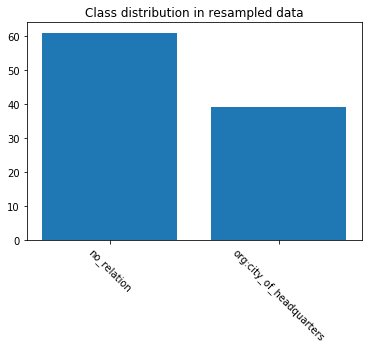

(100, 2)
(100, 178)
(100, 178)


In [68]:
import matplotlib.pyplot as plt
import random

# Verifying that the labels are correct
idx = random.choice(range(len(train_data)))
ex = " ".join(train_data[idx]["token"])
label = train_data[idx]["relation"]
print("Sentence: {}\nLabel: {}".format(ex, label))

class_labels = { v : k for k, v in fep.get_class_labels().items()}
fep_label = class_labels[np.argmax(Y[idx]).astype(int)]
print("FEP label: {}".format(fep_label))

# Verifying class-imbalance issues
labels = np.argmax(Y, axis = 1)
keys, counts = np.unique(labels, return_counts = True)
plt.bar(keys, counts)
plt.title("Class distribution in resampled data")
plt.xticks(keys, [class_labels[k] for k in keys], rotation = -45)
plt.show()

# Verifying that all the shapes work out...
print(Y.shape)
print(X_full.shape)
print(X_middle.shape)

### 4. Evaluating the model and comparing to baselines